In [1]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [4]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')

In [5]:
with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [7]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


In [41]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id',] #'click_environment','click_deviceGroup']
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [42]:
user_clicks = get_click_data()

In [43]:
user_clicks.to_csv('data/user_clicks.csv')

In [357]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


user_id             322897
click_article_id     46033
dtype: int64

# Train/Test Split

Smaller samples are used for GD optimization and testing.

Larger samples are used for validation.

In [45]:
def train_test_split(df, size, leftover_size):
    start = time()
    df = df[df.groupby('user_id').user_id.transform(len) >= (size + leftover_size)]
    print(time() - start, 'seconds to filter down dataframe')
    
    start = time()
    df_train = df.groupby('user_id').apply(lambda x: x.sample(8)) #.reset_index(drop=True)
    print(time() - start, 'seconds to sub-sample dataframe')
    
    start = time()
    df_test = df[~df.index.isin(df_train.index)]
    print(time() - start, 'seconds to get df_test')
    
    return df_train, df_test

In [384]:
df_train, df_test = train_test_split(user_clicks,8,2)

95.36949682235718 seconds to filter down dataframe
37.521403074264526 seconds to sub-sample dataframe
959.681871175766 seconds to get df_test


In [387]:
df_sample = df_train[0:1600]

In [161]:
df_sample_test = df_test[df_test.user_id.isin(df_test.user_id.unique()[0:200])]

In [163]:
df_train.to_csv('data/df_train.csv')
df_test.to_csv('data/df_test.csv')
df_sample.to_csv('data/df_sample.csv')
df_sample_test.to_csv('data/df_sample_test.csv')

In [177]:
print(df_train.shape)
print(df_test.shape)
print(df_sample.shape)
print(df_sample_test.shape)

(683208, 4)
(2027773, 3)
(1600, 4)
(8265, 3)


In [46]:
## Bigger Size
df_train_big, df_test_big = train_test_split(user_clicks,20,10)

90.52367687225342 seconds to filter down dataframe
7.350966930389404 seconds to sub-sample dataframe
0.27716588973999023 seconds to get df_test


In [47]:
# df_train_big.to_csv('data/df_train_big.csv')
# df_test_big.to_csv('data/df_test_big.csv')

In [48]:
# #read back
# df_train_big = pd.read_csv('data/df_train_big.csv')

### Read Back

In [6]:
df_train = pd.read_csv('data/df_train.csv',index_col=0)
df_test = pd.read_csv('data/df_test.csv',index_col=0)

In [6]:
df_sample = pd.read_csv('data/df_sample.csv')
df_sample_test = pd.read_csv('data/df_sample_test.csv',index_col=0)

# Models 1 & 2: Linear and Nonlinear Factorization

In [7]:
from model import *

## 1 Interest Unit

374.1218931674957 seconds


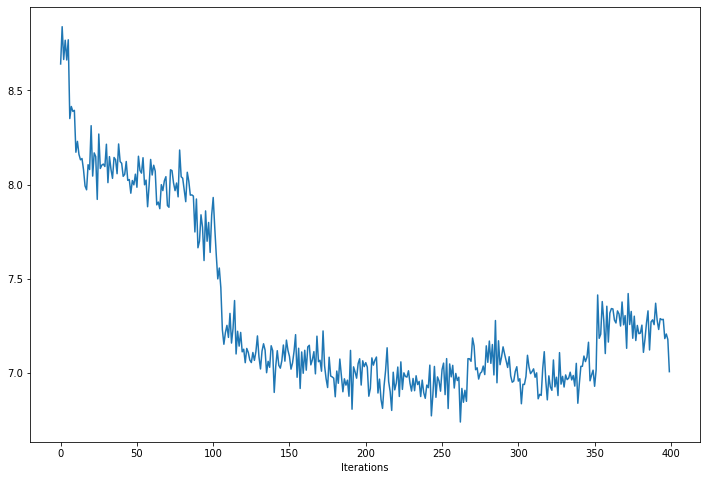

In [11]:
lm = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=1,
    norm_U = True,
)
start = time()
lm.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=400,
    batch_size=16,
    test_size=128,
    hinge_param = 0,
    validation_hinge=0,
)
print(time() - start, 'seconds')

## 2 Interest Units

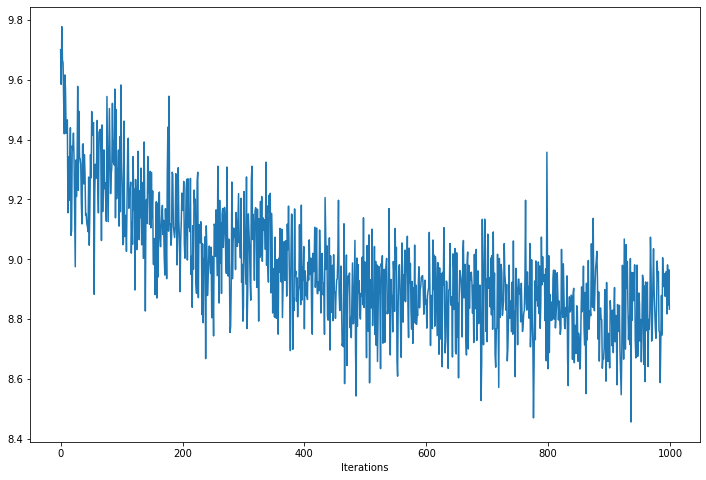

In [11]:
#normalized U
nm2 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=2,
    norm_U=True
)
nm2.gradient_descent_nonlinear(
    test=True,
    alpha=0.1,
    max_iterations=1000,
    test_size=64,
    batch_size=32,
    hinge_param = 0,
    validation_hinge = 0,
    readj_interval=1,
)

## 3 Interest Units

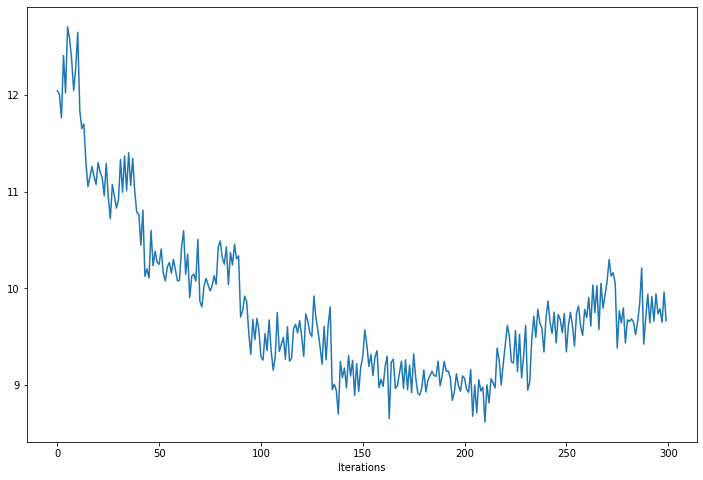

In [8]:
#normalized U
nm3 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=3,
    norm_U=True
)
nm3.gradient_descent_nonlinear(
    test=True,
    alpha=0.25,
    max_iterations=300,
    test_size=64,
    batch_size=32,
    hinge_param = 0.25,
    validation_hinge = 0,
    readj_interval=1,
    norm_U=True
)

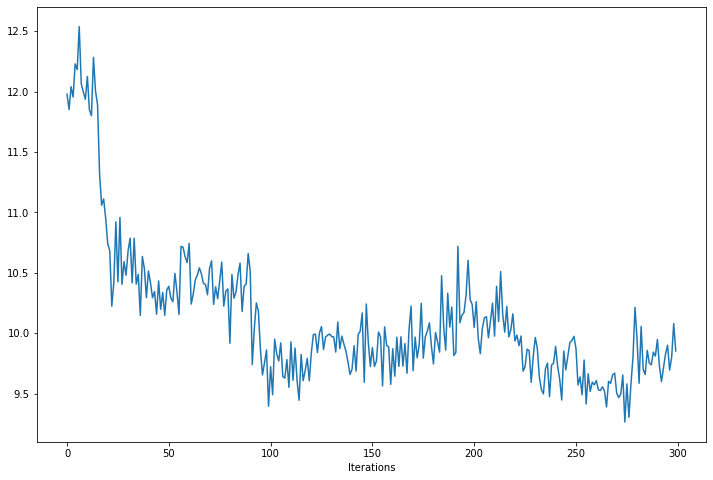

In [9]:
#normalized U
nm3 = NonlinearModel(
    df_sample,
    normalize(embeddings),
    size=8,
    embeddings_size=250,
    T=3,
    norm_U=True
)
nm3.gradient_descent_nonlinear(
    test=True,
    alpha=0.2,
    max_iterations=300,
    test_size=64,
    batch_size=32,
    hinge_param = 0.25,
    validation_hinge = 0,
    readj_interval=1,
    norm_U=True
)